[*********************100%***********************]  1 of 1 completed


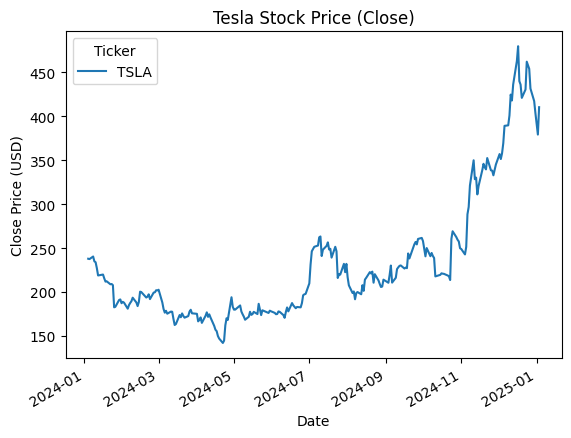

Ticker
TSLA    410.440002
Name: 2025-01-03 00:00:00, dtype: float64
0.6328196067658083


In [132]:
# Import Required Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

seed=np.random.seed(42)

# Fetch Stock Price Data for TSLA
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=1)

tesla_data = yf.download("TSLA", start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
tesla_data['Close'].plot(title="Tesla Stock Price (Close)")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.show()

# Historical Volatility and Parameters

tesla_data['LogReturn'] = np.log(tesla_data['Close'] / tesla_data['Close'].shift(1))
volatility = tesla_data['LogReturn'].std() * np.sqrt(252)  

S0 = tesla_data['Close'].iloc[-1]  # Current Stock Price

print(S0)                          # we get the current price is 410

sigma = volatility                 # Historical Volatility
print(sigma)                       # 0.6328196067658083

#Barrier and Strike Prices
call_K = 420                       # set it a bit higher than S0
call_H_in = 500
put_K = 400                        # set it a bit lower than S0
put_H_in = 320


r = 0.0425                         # Risk-Free Interest Rate
T = 1                              # Time to Maturity (in Years)
N = 252  
nsim = 30000 

Barrier Call Option Price: 0.31
Barrier Put Option Price: 0.72


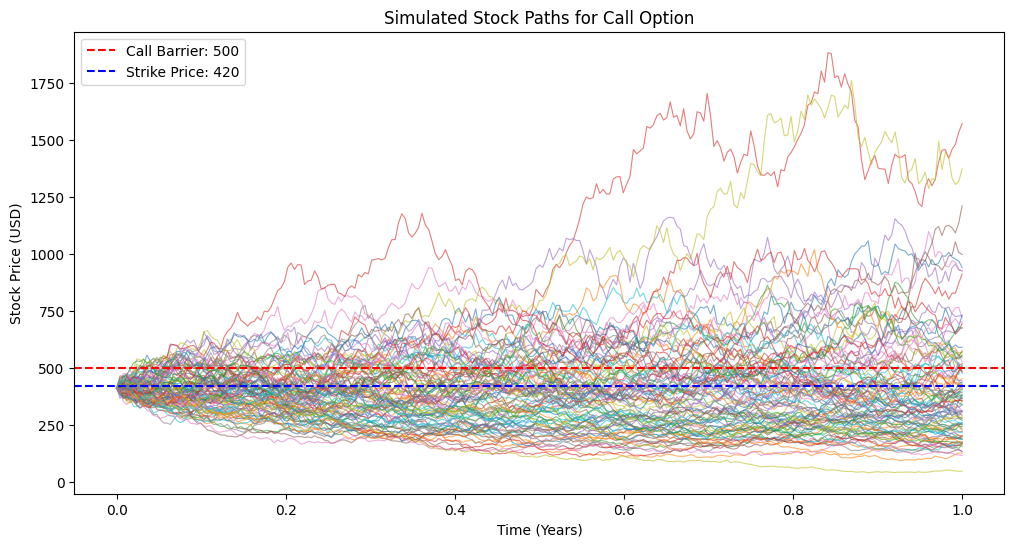

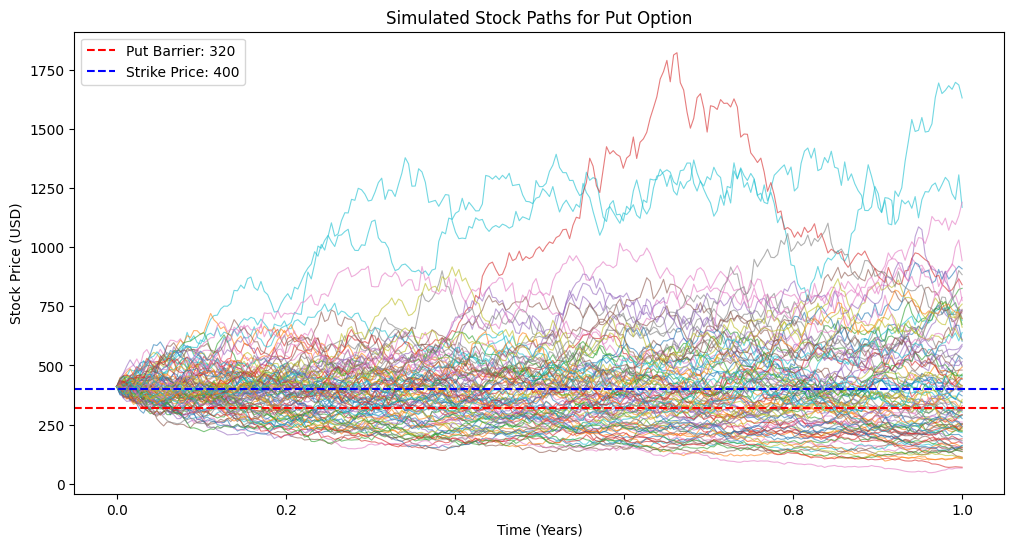

In [133]:
# Simulate Stock Prices
def simulate_stock_price(S0, T, r, sigma, N, n):
    dt = T / N
    Z = np.random.normal(0, 1, (n, N))  # Standard Normal Random Variables
    S = np.zeros((n, N + 1))
    S[:, 0] = S0
    
    for t in range(1, N + 1):
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    
    return S

# Barrier Option Pricing: Call
def calculate_barrier_option_call(S0, K, H, T, r, sigma, N, n):
    stock_paths = simulate_stock_price(S0, T, r, sigma, N, n)
    
    barrier_breached = np.any(stock_paths >= H, axis=1)  # Call Barrier Breach
    payoff = np.where((stock_paths[:, -1] > K) & ~barrier_breached, 
                      stock_paths[:, -1] - K, 0)
    discounted_payoff = np.exp(-r * T) * payoff
    
    return np.mean(discounted_payoff), stock_paths

# Barrier Option Pricing: Put
def calculate_barrier_option_put(S0, K, H, T, r, sigma, N, n):
    stock_paths = simulate_stock_price(S0, T, r, sigma, N, n)
    
    barrier_breached = np.any(stock_paths <= H, axis=1)  # Put Barrier Breach
    payoff = np.where((stock_paths[:, -1] < K) & ~barrier_breached, 
                      K - stock_paths[:, -1], 0)
    discounted_payoff = np.exp(-r * T) * payoff
    
    return np.mean(discounted_payoff), stock_paths

# Calculate Call and Put Barrier Option Prices
call_price, call_paths = calculate_barrier_option_call(S0, call_K, call_H_in , T, r, sigma, N, nsim)
put_price, put_paths = calculate_barrier_option_put(S0, put_K, put_H_in, T, r, sigma, N, nsim)

print(f"Barrier Call Option Price: {call_price:.2f}")
print(f"Barrier Put Option Price: {put_price:.2f}")

# Visualization: Call Option Paths
plt.figure(figsize=(12, 6))
for i in range(100):  # Plot 100 paths
    plt.plot(np.linspace(0, T, N + 1), call_paths[i], lw=0.8, alpha=0.6)
plt.axhline(call_H_in, color='red', linestyle='--', label=f'Call Barrier: {call_H_in}')
plt.axhline(call_K, color='blue', linestyle='--', label=f'Strike Price: {call_K}')
plt.title("Simulated Stock Paths for Call Option")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

# Visualization: Put Option Paths
plt.figure(figsize=(12, 6))
for i in range(100):  # Plot 100 paths
    plt.plot(np.linspace(0, T, N + 1), put_paths[i], lw=0.8, alpha=0.6)
plt.axhline(put_H_in, color='red', linestyle='--', label=f'Put Barrier: {put_H_in}')
plt.axhline(put_K, color='blue', linestyle='--', label=f'Strike Price: {put_K}')
plt.title("Simulated Stock Paths for Put Option")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()
